In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pylab as plt
import seaborn as sns
from wordcloud import WordCloud
from pickle import dump
from pickle import load
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from afinn import Afinn
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, classification_report

In [2]:
def map_sentiment(rating):
    if rating <= 2:
        return 0 #negative review
    else:
        return 1 #positive review

df = pd.read_csv("../CSVInUse/RiverHotelReview.csv")
# drop duplicated index column
df = df.iloc[:, 1:]
df['Sentiment'] = [map_sentiment(x) for x in df['Rating']]
df.head(10)

,Customer_name,Rating,Review_Title,Review,Sentiment
0,d g,2,Great location but that's about it,"Pokey rooms, one working lift for 38 floors, ~...",0
1,Sina,1,The worst stay ever,I booked this hotel through Booking.com. I fil...,0
2,Rob M,3,Parking will cost you.,Price was fantastic. Room was basic. There was...,1
3,Emmanuel R,4,Well located in the loop,I went there for a business trip. The hotel is...,1
4,Adam F,4,"Great Location, Decent Hotel","The location of the hotel is perfect, easily w...",1
5,rktrump,5,Will absolutely stay here again,I would absolutely stay here again. I sprung f...,1
6,Andrea L,1,Horrendous,We were so excited to find such a seemingly ni...,0
7,manuh620,4,Location is great,The hotel is very well situated for a trip to ...,1
8,Me_n_my_rucksack,5,"Exactly what we wanted.... perfect location, ...",When visiting a City you are unfamilliar with ...,1
9,susan,4,"Excellent location, comfortable stay",River Hotel is in an excellent location for do...,1


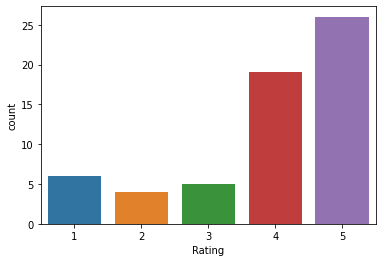

In [3]:
# generate barchart based on hotel ratings 
df = pd.read_csv("../CSVInUse/RiverHotelReview.csv")
sns.countplot(x ='Rating', data = df)
plt.show()

In [4]:
wordnet=WordNetLemmatizer()
stop_words=stopwords.words('english')
not_stopwords = ("aren", "aren't", "couldn", "couldn't", "didn", "didn't",
                 "doesn", "doesn't", "don", "don't", "hadn", "hadn't", "hasn",
                 "hasn't", "haven", "haven't", "isn", "isn't", "mustn",
                 "mustn't", "no", "not", "only", "shouldn", "shouldn't",
                 "should've", "wasn", "wasn't", "weren", "weren't", "will",
                 "wouldn", "wouldn't", "won't", "very")
stop_words_ = [words for words in stop_words if words not in not_stopwords]
stop_words_.append("I")
stop_words_.append("the")
stop_words_.append("s")
stop_words_.extend([
    "will", "always", "go", "one", "very", "good", "only", "mr", "lot", "two",
    "th", "etc", "don", "due", "didn", "since", "nt", "ms", "ok", "almost",
    "put", "pm", "till", "add", "let", "hotel", "able", "per", "st", 
    "couldn", "yet", "par", "hi", "well", "would", "I", "the", "s", 
    "also", "great", "get", "like", "take", "thank"
])
print(stop_words_)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'own', 'same', 'so', 'than', 'too', 's', 't', 'can'

In [5]:
nlp=spacy.load('en_core_web_sm')
reviewtext = []

for i in range(0, len(df)):
    df['Review_Combined'] = df['Review_Title'] + str(' ') + df['Review']
    review = re.sub('[^a-zA-Z]', ' ', df['Review_Combined'][i])
    review = review.lower()
    review = review.split()
    review = nlp(' '.join(review))
    review = [token.lemma_ for token in review]
    review = [word for word in review if word not in stop_words_]
    review = ' '.join(review)
    reviewtext.append(review)

pd.DataFrame(reviewtext).head()

,0
0,location pokey room work lift floor minute que...
1,bad stay ever book booking com filter star pro...
2,parking cost price fantastic room basic pull c...
3,locate loop business trip clean ideally locate...
4,location decent location perfect easily within...


In [9]:
df['Cleaned_Review'] = reviewtext
clean_review_words = " ".join(df['Cleaned_Review'])
clean_review_words = clean_review_words.split()
all_words = len(clean_review_words)
print('Total number of words in cleaned review is {}'.format(all_words))
word_freq = nltk.FreqDist(clean_review_words)
freq_data_all = pd.DataFrame(word_freq.most_common(all_words), columns=['Word', 'Frequency'])
freq_data_all['Percentage'] = round(((freq_data_all.Frequency / freq_data_all.Frequency.sum()) * 100),2)
print('No of unique words {}'.format(len(freq_data_all)))
print(freq_data_all[0:10])
# run afn then run next histplot

Total number of words in cleaned review is 2137
No of unique words 565
       Word  Frequency  Percentage
0      room         92        4.31
1  location         66        3.09
2      view         33        1.54
3      stay         32        1.50
4     river         32        1.50
5       bed         31        1.45
6     clean         25        1.17
7     check         25        1.17
8     staff         23        1.08
9        no         22        1.03


<AxesSubplot:xlabel='Cleaned_Review', ylabel='Count'>

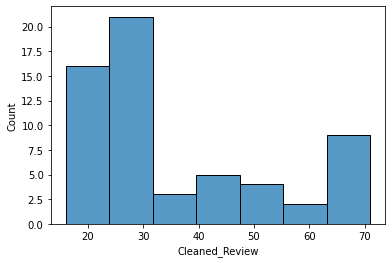

In [7]:
# generate barchart based on word count for cleaned reviews 
df['Cleaned_Review'] = pd.Series([len(item.split()) for item in df['Cleaned_Review']])
sns.histplot(df['Cleaned_Review'])

In [10]:
afn=Afinn()
score = [afn.score(item) for item in df['Cleaned_Review']]
Affin_sentiment = [1 if score > 0 else 0 for score in score]
df['Affin_score'] = score
df['Affin_sentiment'] = Affin_sentiment
df[df['Affin_sentiment'] == 0]['Cleaned_Review']
# run positive wordcloud next

0     location pokey room work lift floor minute que...
1     bad stay ever book booking com filter star pro...
2     parking cost price fantastic room basic pull c...
6     horrendous excited find seemingly nice bailabl...
11    horrendous excited find seemingly nice bailabl...
17    stay away overpriced ugly ever stay price abso...
22    stay away overpriced ugly ever stay price abso...
25    location versus price location chicago low pri...
26    short trip come weekend birthday trip room was...
30    location versus price location chicago low pri...
31    short trip come weekend birthday trip room was...
46    picture line not reflect realty check check st...
51    picture line not reflect realty check check st...
58    room allow dog not bad thing however room dry ...
Name: Cleaned_Review, dtype: object

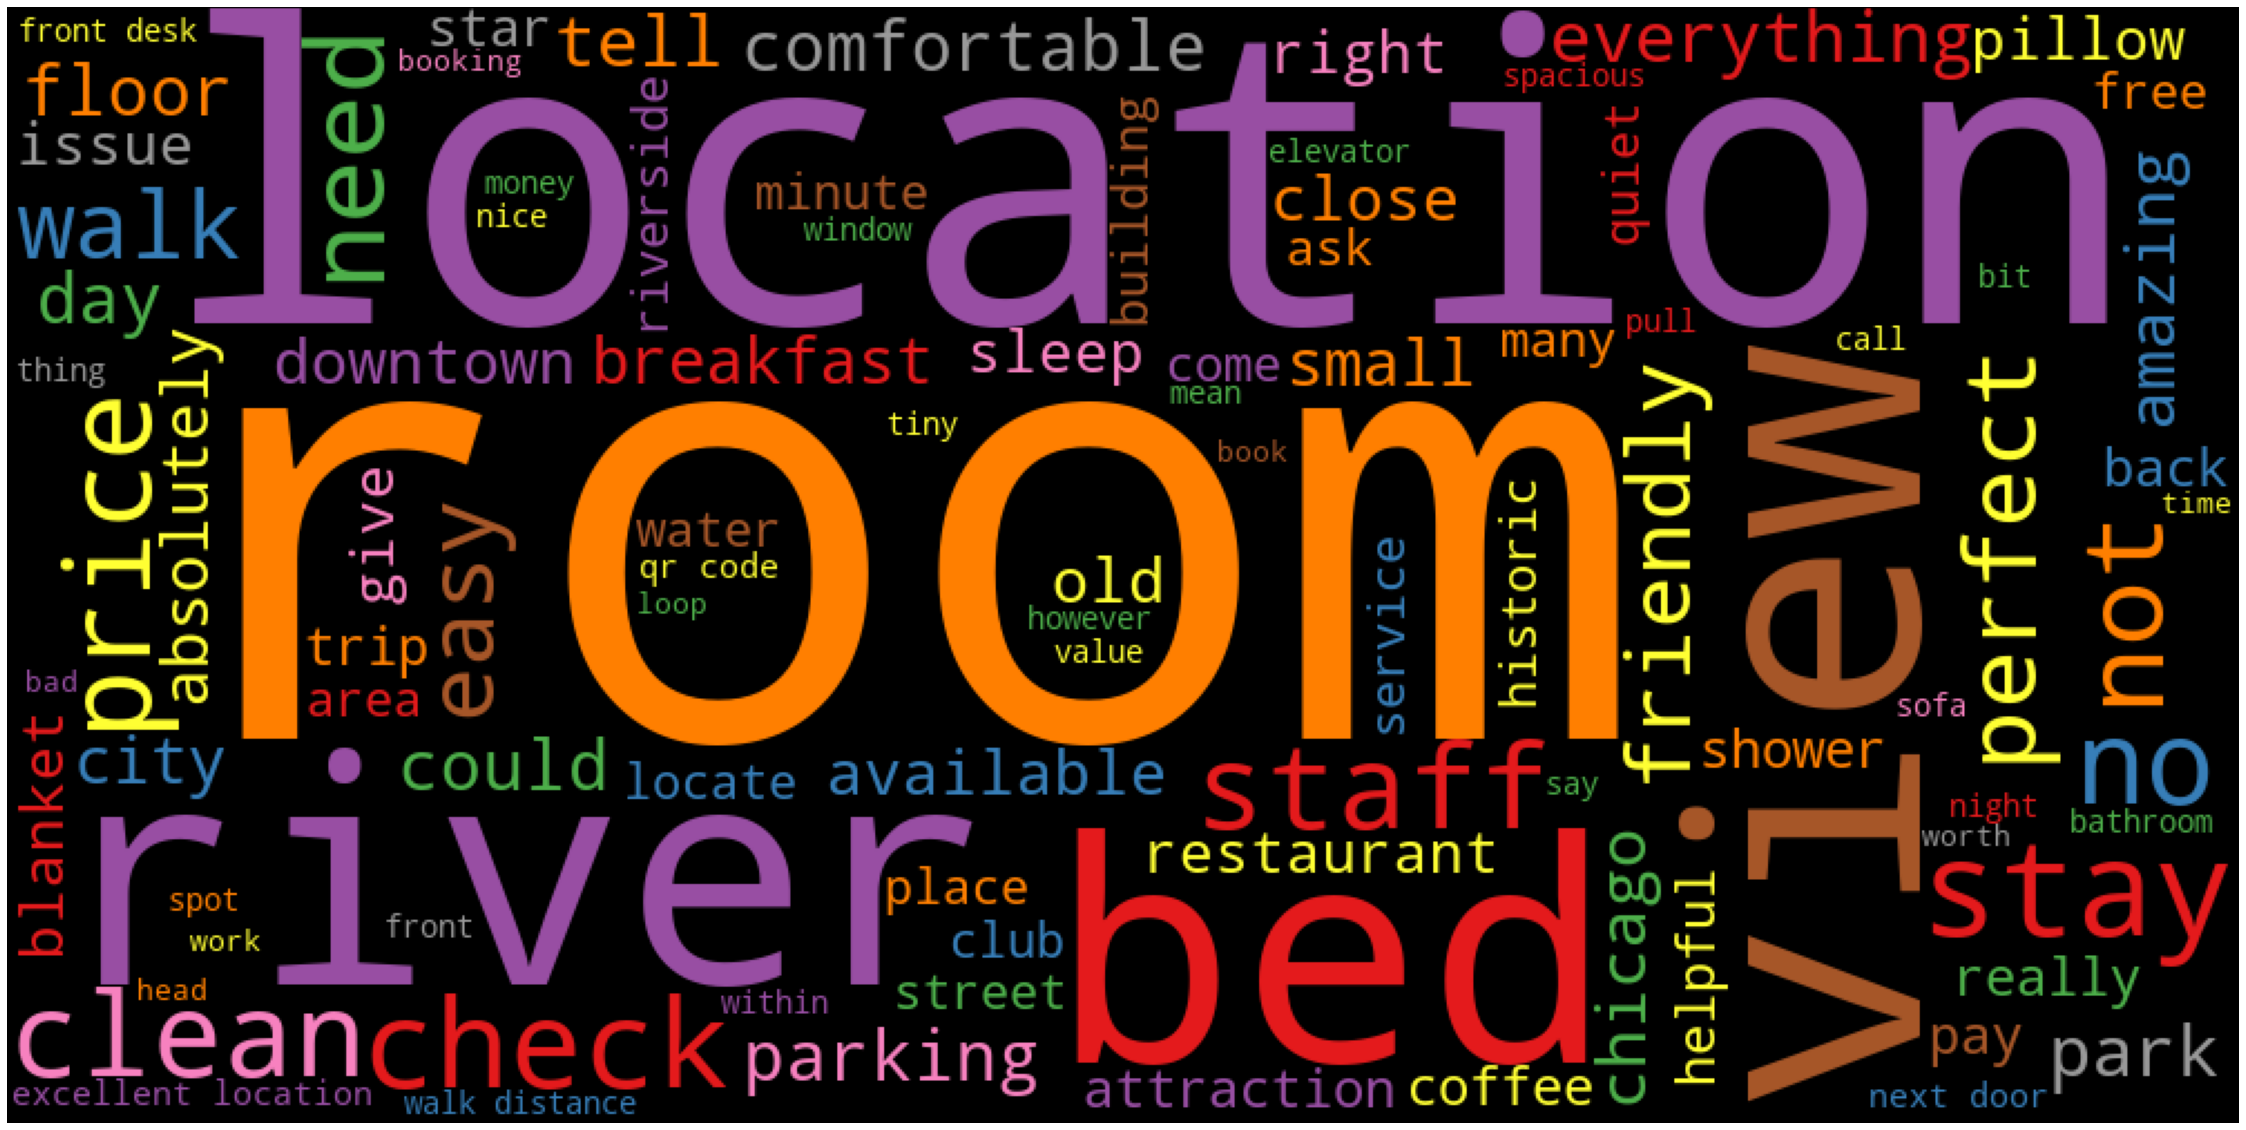

In [11]:
# generate wordcloud based on most frequently typed word in review text
wordcloud = WordCloud(
    width=1000,
    height=500,
    colormap='Set1',
    stopwords=stop_words_,
    max_words=100
).generate(str(reviewtext))

plt.figure(figsize=(40, 30))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

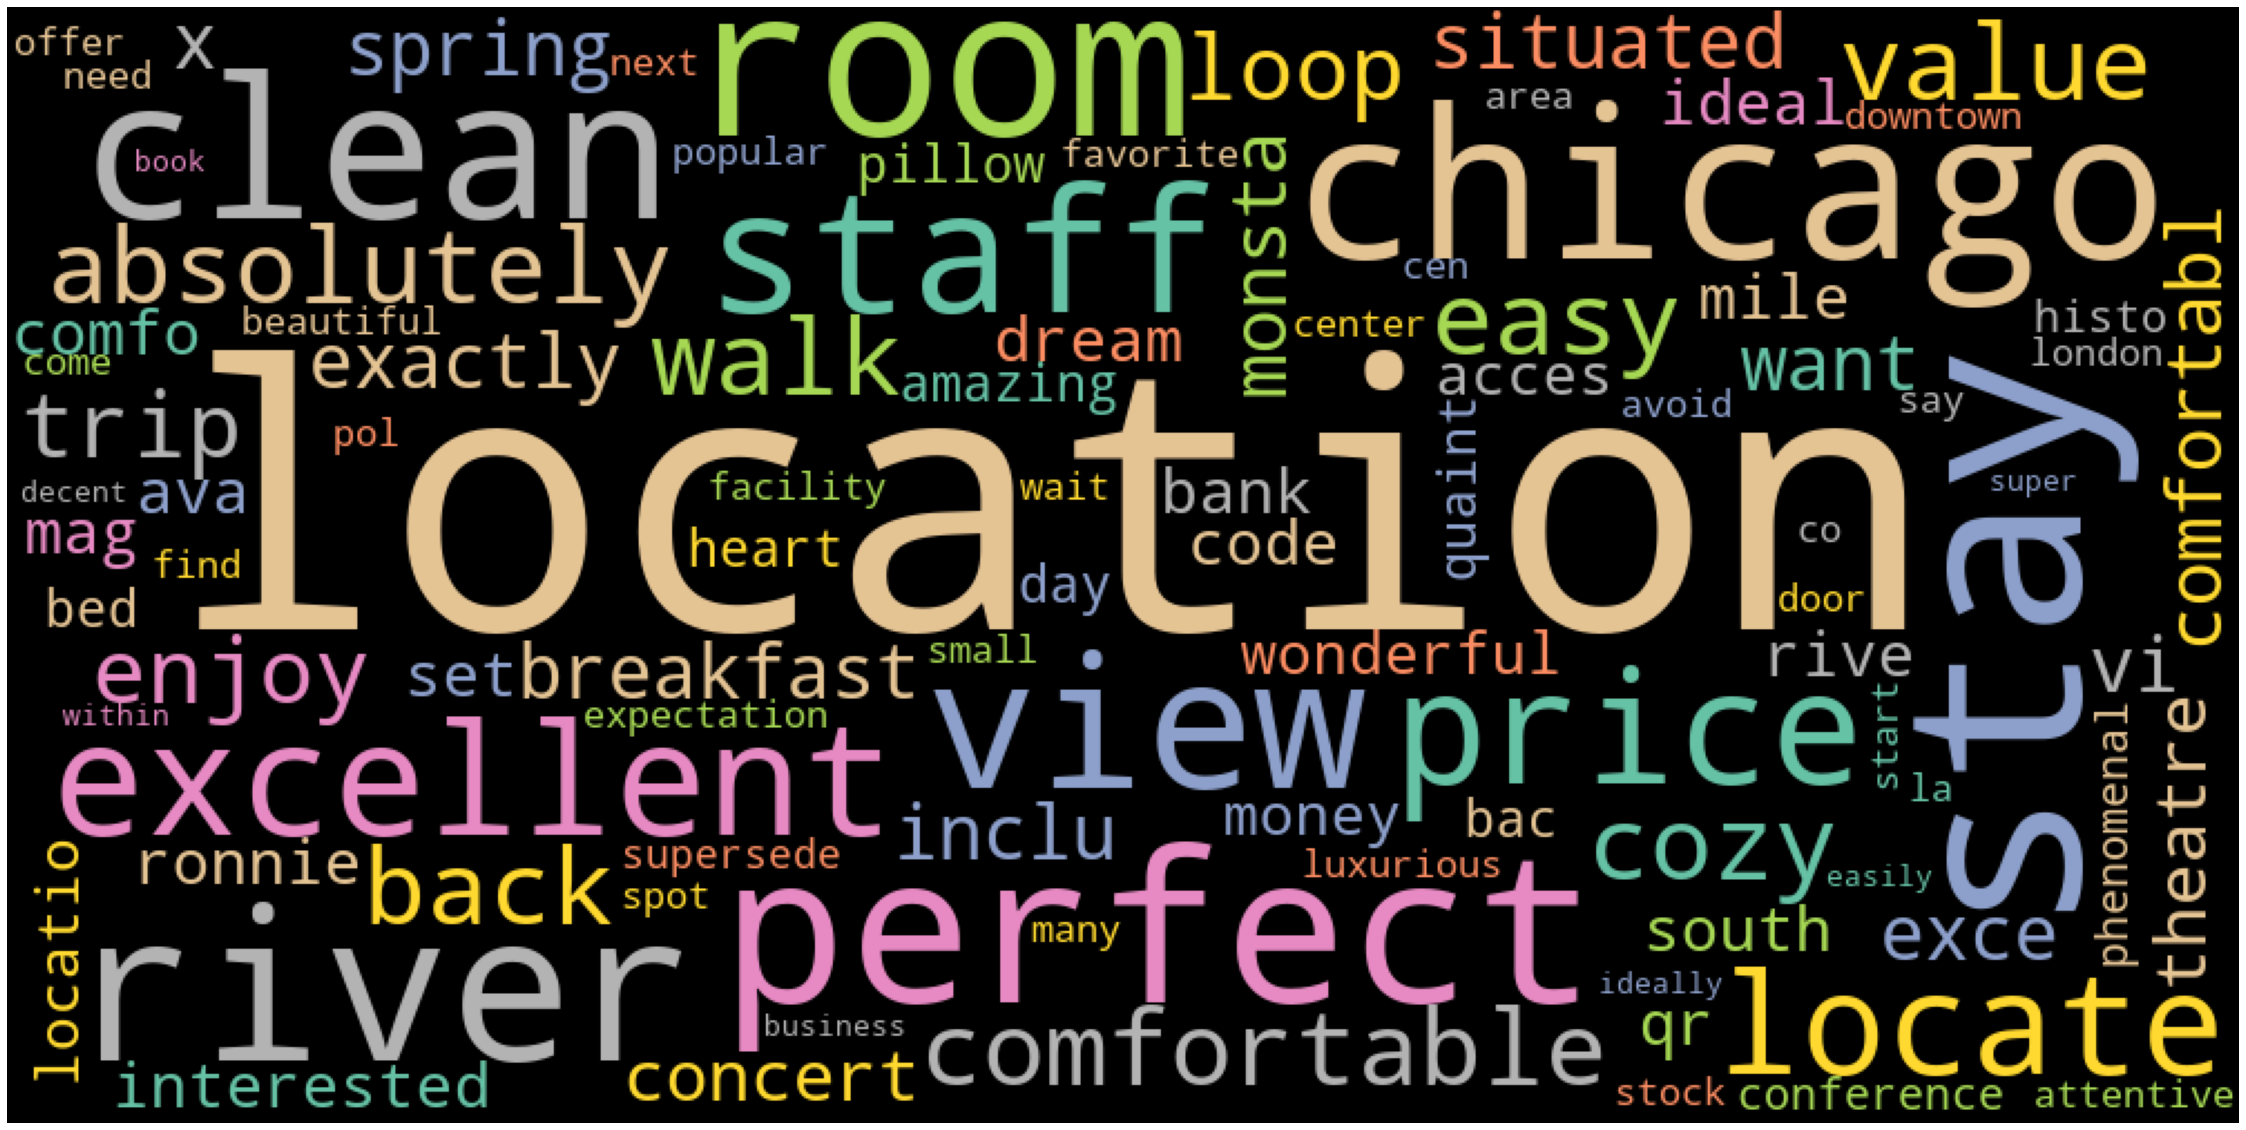

In [12]:
# generate wordcloud based on most frequently typed word in positive sentiment review text
wordcloud = WordCloud(
    width=1000,
    height=500,
    colormap='Set2',
    stopwords=stop_words_,
    max_words=100
).generate(str(df[df['Affin_sentiment'] == 1]['Cleaned_Review']))

plt.figure(figsize=(40, 30))
plt.imshow(wordcloud)
plt.axis('off')
# run afinn again before running this wordcloud
plt.show()

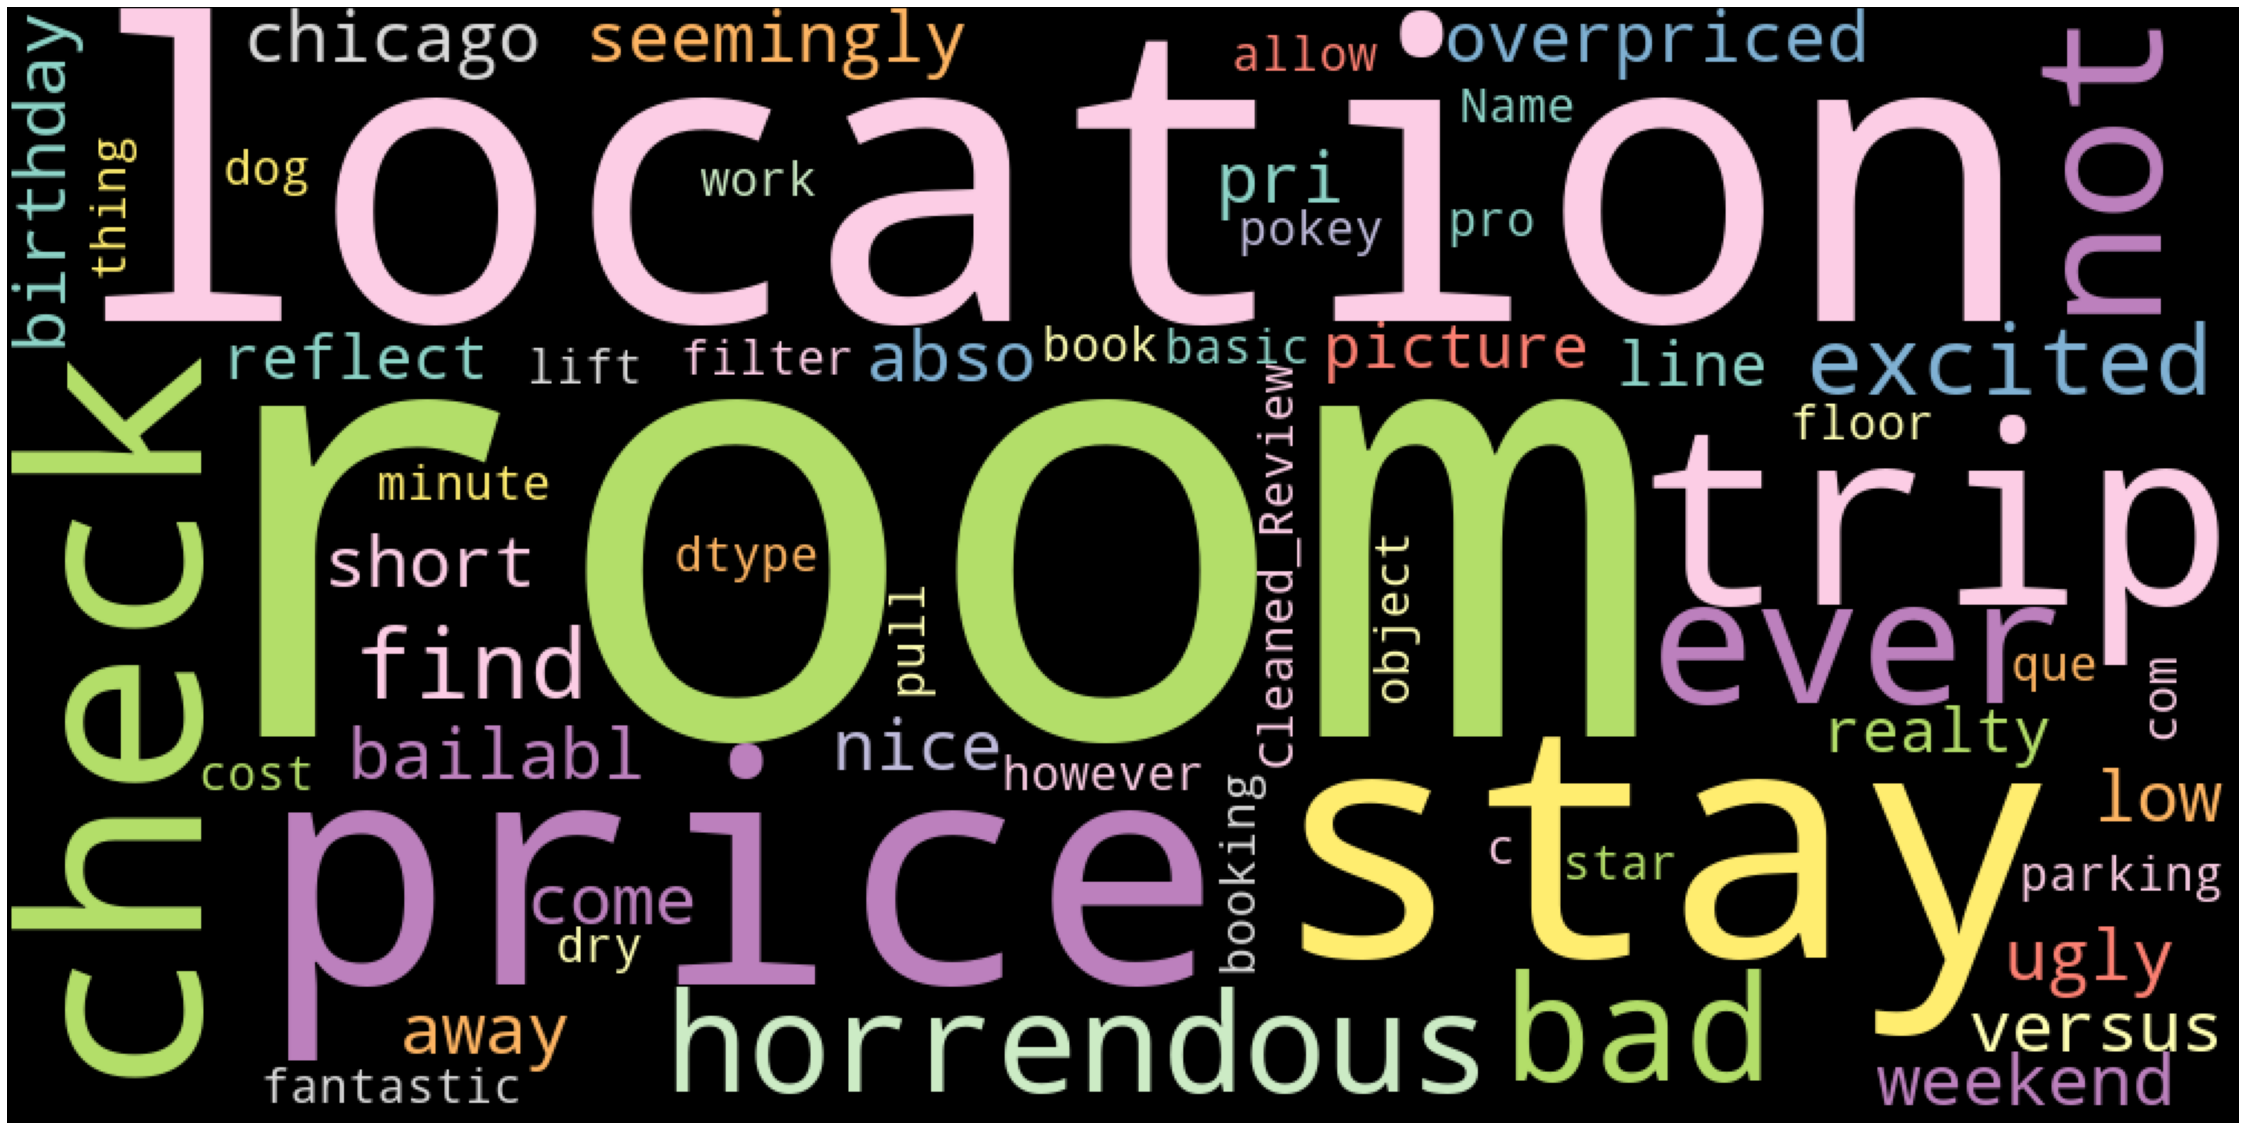

In [13]:
# generate wordcloud based on most frequently typed word in negative sentiment review text
wordcloud = WordCloud(
    width=1000,
    height=500,
    colormap='Set3',
    stopwords=stop_words_,
    max_words=100
).generate(str(df[df['Affin_sentiment'] == 0]['Cleaned_Review']))

plt.figure(figsize=(40, 30))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<AxesSubplot:title={'center':'review terms by frequency'}>

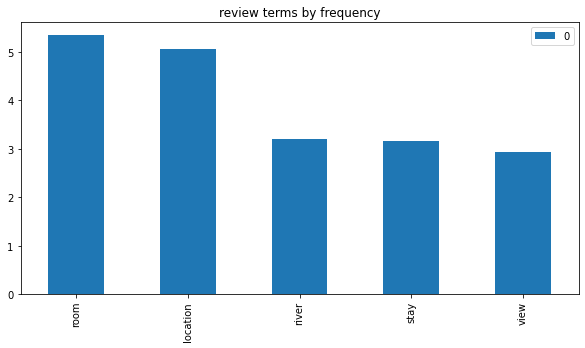

In [14]:
# generate barchart based on review text term frequency
tfidf2 = TfidfVectorizer(norm="l2", analyzer='word', stop_words=stop_words_, ngram_range=(1,1))
tfidf2_x = tfidf2.fit_transform(reviewtext)
termfreq = pd.DataFrame(tfidf2_x.sum(axis=0), columns=tfidf2.get_feature_names()).T.sort_values(0, ascending=False).head()
termfreq.plot(kind='bar', title='review terms by frequency', figsize=(10, 5))

In [18]:
# machine learning model function
def c_matrix(X_train, X_test, y_train, y_test, model):
    # make prediction
    predict_train = model.predict(X_train)
    predict_test = model.predict(X_test)
    # test accuracy
    accuracy_train = model.score(X_train, y_train)
    accuracy_test = model.score(X_test, y_test)
    print('Accuracy for Train set {}'.format(accuracy_train))
    print('Accuracy for Test set {}'.format(accuracy_test))
    # f1 score = 2 * (precision * recall) / (precision + recall)
    f1_score = metrics.f1_score(y_train, predict_train)
    # print 1 can classify observation into correct class vs 0 cannot
    print('F1 Score {}'.format(f1_score))
    print(classification_report(y_test, predict_test))
    plot_confusion_matrix(estimator=model, X=X_test, y_true=y_test, cmap = 'rainbow')
    plt.grid(False)
# oversampling 
over = SMOTE(sampling_strategy=1, random_state=0)
# convert word token to feature vector for vocab input 
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,1))
review_tfidf = tfidf.fit_transform(reviewtext)
X_over, y_over = over.fit_resample(review_tfidf, df['Affin_sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, random_state=7, test_size=0.20, stratify=y_over)


Accuracy for Train set 1.0
Accuracy for Test set 1.0
F1 Score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        10

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



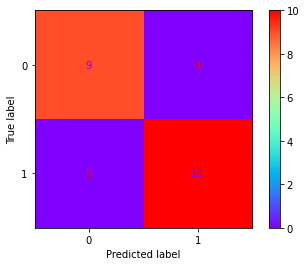

In [19]:
# regression test
model_lr = LogisticRegression(C=5, penalty='l2', random_state=0)
model_lr.fit(X_train, y_train)
c_matrix(X_train, X_test, y_train, y_test, model_lr)

Accuracy for Train set 0.5068493150684932
Accuracy for Test set 0.47368421052631576
F1 Score 0.0
              precision    recall  f1-score   support

           0       0.47      1.00      0.64         9
           1       0.00      0.00      0.00        10

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



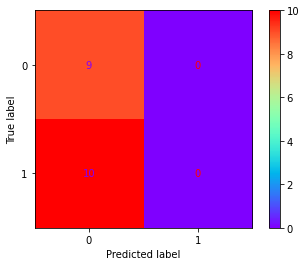

In [20]:
# KNN
model_knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
model_knn.fit(X_train, y_train)
c_matrix(X_train, X_test, y_train, y_test, model_knn)

Accuracy for Train set 1.0
Accuracy for Test set 1.0
F1 Score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        10

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



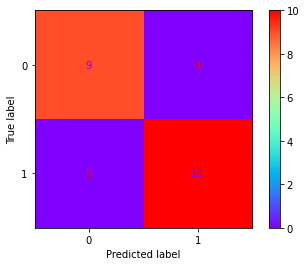

In [21]:
# Naive Bayes
model_naive = MultinomialNB()
model_naive.fit(X_train, y_train)
c_matrix(X_train, X_test, y_train, y_test, model_naive)